# Common imports

In [1]:
import re,os
import numpy as np
import pandas as pd
from glob import glob
import sklearn
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
from skimage.transform import rotate
from sklearn import tree
from sklearn.metrics import mean_squared_error
import matplotlib.image as mpimg
from matplotlib.ticker import MultipleLocator,FormatStrFormatter,AutoMinorLocator

# Constants

In [2]:
SHP=(30,30,3)
BAND_ORDER=[2,0,1]
BANDS=["F814W","F125W","F160W"]

# Data Processing Functions

In [3]:
def rescale(a):
    a=a-a.min()
    a=a/a.max()
    return a

def get_angle(d):
    fit=PCA(n_components=2).fit(
        np.argwhere(d>=np.quantile(d,.75)))
    return np.arctan2(*fit.components_[0])

def rotation(d):
    fl=np.apply_along_axis(max,2,d.reshape(SHP))
    angle=get_angle(fl)
    for i in range(0,d.shape[2]):
        d[:,:,i]=rotate(d[:,:,i],
                        angle/np.pi*180-90,
                        clip=True)
    return d

def normalise_all(a,lower_q,upper_q):
    a=a.copy()
    x=SHP[0]*SHP[1]
    L,U=np.quantile(a,[lower_q,upper_q])
    a=np.clip(a,L,U)
    for i in range(0,len(a)):
        d=a[i,:].reshape(SHP)
        d=rotation(d)
        a[i,:]=d.flatten()
    return a

def get_data():
    L=[]
    def f(x): return re.search("[^/]+(?=.npy)",x)[0]
    fns=[x for x in map(f,glob("CANDELS/*.npy"))]
    skip=[]
    for fn in fns:
        x=np.load("CANDELS/%s.npy" % fn,allow_pickle=True)
        skip.append(any([x[:,:,i].max()==0 for i in range(0,SHP[2])]))
        L.append(x.flatten())
    a=np.row_stack(L)
    I=(a.std(axis=1)!=0) & ~(np.array(skip))
    return a[I],np.array(fns)[I]

def get_catalog():
    def f(x): return re.search("[^/]+(?=.npy)",x)[0]
    fns=[x for x in map(f , glob("CANDELS/*.npy"))]
    cat=pd.read_csv("CANDELS/catalog.csv")
    cat=cat[cat.ID.isin(fns)]
    cat=cat.sort_values("ID")
    cat=cat.reset_index(drop=True)
    return cat


# Image Generation

In [4]:
import matplotlib.image as mpimg

def make_image(I,figsize):
    L=[]
    for i in I.flatten():
        id=re.search("[0-9]+",i)[0].zfill(5)
        fn="GDS_RGBs/GDS_%s.png" % id
        if os.path.exists(fn): L.append(mpimg.imread(fn))
    fig=plt.figure(figsize=figsize)
    grid=ImageGrid(fig,111,nrows_ncols=figsize,axes_pad=0)
    for ax, im in zip(grid,L):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(im)
    plt.tight_layout()
    return plt

from mpl_toolkits.axes_grid1 import ImageGrid

def make_image_pre(X,figsize,title=None):
    L=[]
    for i in range(0,len(X)):
        L.append(X[i,:].reshape(SHP))
    fig=plt.figure(figsize=figsize)
    if not title is None: fig.suptitle(title, fontsize=14)
    grid=ImageGrid(fig,111,nrows_ncols=figsize,axes_pad=0)
    for ax, im in zip(grid,L):
        r=im[:,:,0]; r-=r.min()
        if r.max()!=0: r/=r.max()
        g=im[:,:,1]; g-=g.min()
        if g.max()!=0: g/=g.max()
        b=im[:,:,2]; b-=b.min()
        if b.max()!=0: b/=b.max()
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(np.dstack([g,r,b]))
    #plt.tight_layout(h_pad=10)
    return plt

# Data

In [5]:
raw_data,indexes=get_data()
norm_data=normalise_all(raw_data,0,.99)
print("size",len(raw_data))

size 10243


# PCA

In [6]:
pca=PCA(.96).fit(norm_data)
scores=pca.transform(norm_data)
lik=pca.score_samples(norm_data)
print(pca.n_components_)

12


k 2
k 4
k 8
k 16
k 32
k 64
k 128
k 256
k 512
k 1024
k 2048


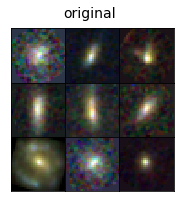

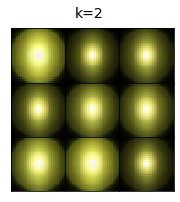

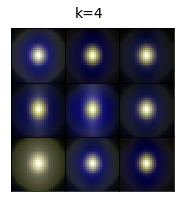

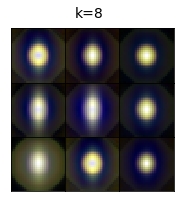

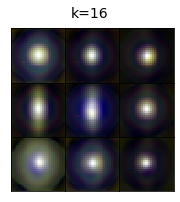

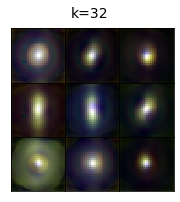

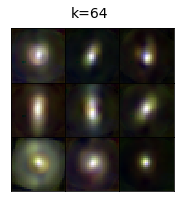

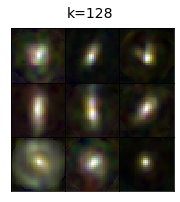

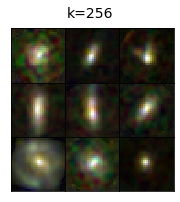

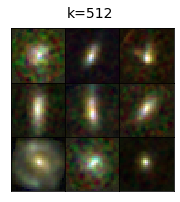

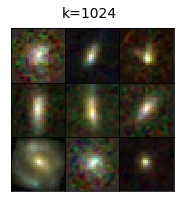

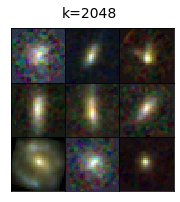

In [8]:
examples=[0,6,10,11,24,33,43,45,50]
n=norm_data[examples]
make_image_pre(n,(3,3))
plt.suptitle("original", fontsize=14)
plt.savefig("recon/recon0.png")
for k in [2,4,8,16,32,64,128,256,512,1024,2048]:
    print("k",k)
    p=PCA(k).fit(norm_data)
    s=p.inverse_transform(p.transform(n))
    fn="recon/recon%d.png" % k
    make_image_pre(s,(3,3),"k=%s" % k).savefig(fn)

# Checks

0.9619767
0.7647773


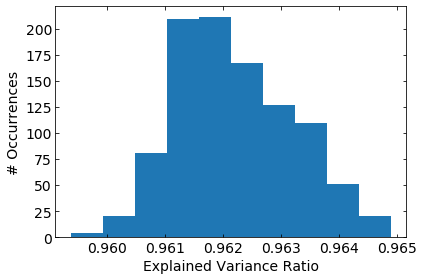

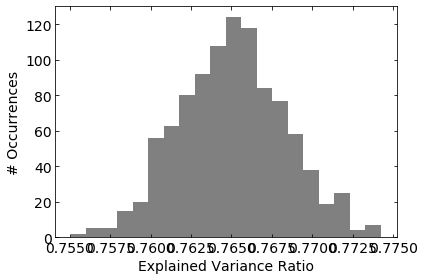

In [10]:
k=12
L=[];M=[]
print(np.sum(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_[0])
for i in range(0,1000):
    #print(i)
    idx=np.random.choice(range(0,len(norm_data)),int(.7*len(norm_data)),replace=False)
    p=PCA(k).fit(norm_data[idx])
    L.append(np.sum(p.explained_variance_ratio_))
    M.append(p.explained_variance_ratio_[0])
_=plt.hist(L)
plt.ylabel("# Occurrences", fontsize=14)
plt.xlabel("Explained Variance Ratio", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
plt.tight_layout()
plt.savefig("bootstrap12.png")
plt.show()

plt.clf()
_=plt.hist(M,color="gray",bins=20)
plt.ylabel("# Occurrences", fontsize=14)
plt.xlabel("Explained Variance Ratio", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
plt.tight_layout()
plt.savefig("bootstrap1.png")

# Outlier Detection

/home/carterrhea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  from ipykernel import kernelapp as app
/home/carterrhea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/carterrhea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


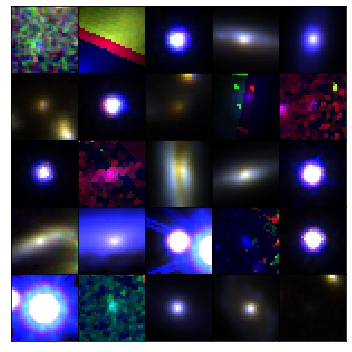

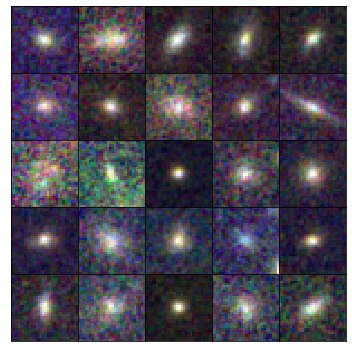

In [11]:
lik_idx=indexes[np.argsort(lik)]
P=make_image(lik_idx[0:25],(5,5))
P.tight_layout()
P.savefig("most-rare.png")
P=make_image(np.flip(lik_idx)[0:25],(5,5))
P.tight_layout()
P.savefig("least-rare.png")

# Sample size, eigengalaxies, and explained variance contour plot

In [ ]:
L=[]
pca_n=40
for s in range(1000,10400,200):
    idx=np.random.choice(range(0,len(norm_data)),s,replace=False)
    for r in range(0,100):
        p=PCA(pca_n).fit(norm_data[idx])
        for n in range(0,pca_n):
            L.append(dict(n=n,s=s,r=r,v=np.cumsum(p.explained_variance_ratio_)[n]))
X=pd.DataFrame(L)
X.n=X.n+1
X=X.groupby(["s","n"]).median()
X=X.reset_index()
del X["r"]
X=X.pivot('s', 'n')
x=X.columns.levels[1].values
y=X.index.values
z=X.values
Xi,Yi = np.meshgrid(x, y)
lvls=[.94,.95,.96,.97,.98,.99]
xx=plt.contour(Yi,Xi,z,levels=lvls,colors="black")
xx.clabel(xx.levels)
plt.ylabel("Eigengalaxies", fontsize=14)
plt.xlabel("Sample size", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
plt.tight_layout()
#plt.savefig("pca-over-samples.pdf")
plt.show()

# Cumulative sum of explained variance.

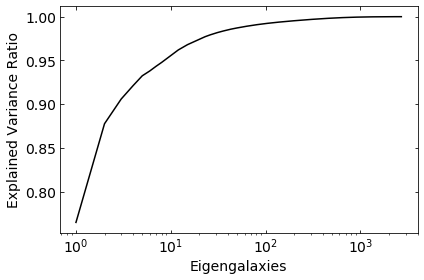

In [7]:
pca_all=PCA().fit(norm_data)
plt.plot(range(1,pca_all.n_components_+1),
         np.cumsum(pca_all.explained_variance_ratio_),
         color="black")
plt.ylabel("Explained Variance Ratio", fontsize=14)
plt.xlabel("Eigengalaxies", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
plt.xscale("log")
plt.tight_layout()
plt.savefig("cum-var.pdf")
plt.show()

# Reconstruction Error

In [ ]:
recon_data=np.dot(scores,pca.components_)+pca.mean_
idx=(norm_data!=0)
sm=norm_data.sum(axis=1)
df=(norm_data-recon_data).sum(axis=1)
sse=df/sm
sse=sse[(sse<=.05) & (sse>=-.05)]
print(((sse>=-.025) & (sse<=.025)).sum() / len(sse))
plt.hist(sse,color="gray",bins=100)
plt.xlabel("Fractional difference", fontsize=14)
plt.ylabel("Number of objects", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in",which='minor')
plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
plt.tight_layout()
#plt.savefig("flux-diff-hist.pdf")
plt.show()

# The Eigengalaxies

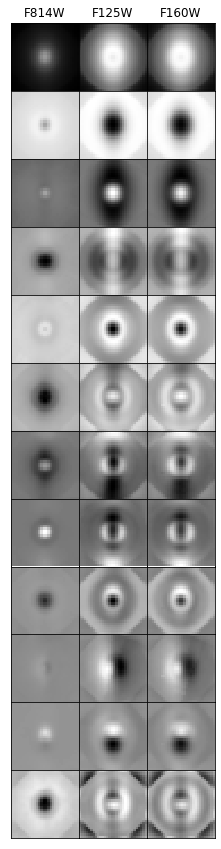

In [8]:
L=[]
N=pca.n_components_
for i in range(0,N):
    comp=pca.components_[i]
    comp=comp.reshape(SHP)
    mn=comp.min();mx=comp.max()
    for j in BAND_ORDER: L.append((mn,mx,comp[:,:,j]))
fig=plt.figure(figsize=(N,3*5))
grid=ImageGrid(fig,111,nrows_ncols=(N,3),axes_pad=0)
for i,b in enumerate(BANDS): grid[i].set_title(b)
for ax, tup in zip(grid,L):
    ax.set_xticks([])
    ax.set_yticks([])
    mn,mx,im=tup
    ax.imshow(im,cmap="gray", aspect="auto",vmin=mn,vmax=mx)
#plt.savefig("components.png")
plt.show()

# Imputing Values

In [ ]:
from pyppca import ppca
from sklearn.impute import SimpleImputer

np.random.seed(22)
cens_data=norm_data.copy()
miss_rows_idx=np.random.choice(indexes,int(len(norm_data)/20),replace=False)
for i in miss_rows_idx:
    d=cens_data[indexes==i].copy().reshape(SHP)
    off=np.random.choice([0,1,2],1)
    d[:,:,off]=np.nan
    cens_data[indexes==i]=d.flatten()
C,ss,M,X,y_ppca=ppca(cens_data,10,False)
inc_idx=np.isin(indexes,miss_rows_idx)
y_ppca=y_ppca[inc_idx]
real_sum=norm_data[inc_idx].sum(axis=1)
y_ppca_del=(norm_data[inc_idx]-y_ppca).sum(axis=1)
y_ppca_res=y_ppca_del/real_sum
less10=((y_ppca_res>=-.1)&(y_ppca_res<=.1)).sum()/len(y_ppca_res)
print("within 10%",less10) 

plt.hist(y_ppca_res,bins=100,color="gray")
plt.xlabel("Fractional difference", fontsize=14)
plt.ylabel("Number of objects", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in",which='minor')
plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)

plt.tight_layout()
#plt.savefig("recovery-pca.pdf")
plt.show()

In [ ]:
Example generation

In [ ]:
norm_samp=norm_data[inc_idx]
cens_samp=cens_data[inc_idx]
miss_rows_samp=np.random.choice(range(0,len(norm_samp)),20,replace=False)
for i in miss_rows_samp:
    L=[]
    x0=norm_samp[i].reshape(SHP)
    x1=cens_samp[i].reshape(SHP)
    x2=y_ppca[i].reshape(SHP)
    mn=x0.min();mx=x0.max()
    for k in BAND_ORDER: L.append(x0[:,:,k])
    for k in BAND_ORDER: L.append(x1[:,:,k])
    for k in BAND_ORDER: L.append(x2[:,:,k])
    fig=plt.figure(figsize=(3*2,3*2))
    grid=ImageGrid(fig,111,nrows_ncols=(3,3),axes_pad=0)
    for i,b in enumerate(BANDS): grid[i].set_title(b)
    for ax, im in zip(grid,L):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(im,cmap="gray",aspect="auto",vmin=mn,vmax=mx)
    plt.show()

# Image Query

Example generator for image queries.

In [ ]:
np.random.seed(1)

for z in range(0,150):
    ref_id=np.random.choice(range(0,len(scores)),1)
    ref=scores[ref_id]
    D=(((scores-ref)**2)**.5).sum(axis=1)
    D=pd.DataFrame(dict(v=D,i=indexes))
    D=D.sort_values("v").head(9)
    make_image(D.i.values,(3,3)).savefig("nn/%d.png" % z)


# Affinity Propagation Clustering

In [ ]:
from sklearn.cluster import AffinityPropagation
clust=AffinityPropagation(damping=0.9,convergence_iter=100,max_iter=1000)
clust=clust.fit(scores)

In [ ]:
import os

l=clust.labels_
G=pd.DataFrame(dict(l=l)).groupby("l").l.count()
df=pd.DataFrame(dict(l=G.index,cnt=G.values))
df=df.sort_values("cnt",ascending=False)
df=df.head(100)

print("labels",len(np.unique(l)))
print("min",np.min(G))
print("max",np.max(G))
print("mean",np.median(G))
print("median",np.median(G))

for _,r in df.iterrows():
    print(r.l,int(r.cnt/10)+1)
    make_image(indexes[l==r.l],(int(r.cnt/10)+1,10)).savefig("clustering/%d.png" % r.l)
